In [2]:
"""
  Copyright (c) 2018 LG Electronics Inc.
  SPDX-License-Identifier: GPL-3.0-or-later
""" 
import keras
import subprocess
from os import path
import pandas as pd
import json

# see models here - https://www.tensorflow.org/lite/guide/hosted_models
STORAGE_LINK = "https://storage.googleapis.com/download.tensorflow.org/models/mobilenet_v1_2018_08_02/"
ADB_LOCAL = path.expanduser("~/Library/Android/sdk/platform-tools/adb")  # for MacOS

ALPHA = ["1.0","0.75","0.5","0.25"]
SIZE = ["224","192","160","128"]
REP_DATA = "repdata.py"

OP_TYPE = ["float", "float16", "uint8", "int8"]

KEYS = [[a,b] for a in ALPHA for b in SIZE]
MOBILENET = "mobilenet_v1"
df = pd.DataFrame({"model":[], "alpha":[], "size":[], "gpu":[], "nnapi":[], "op": [], "size_init":[],
                   "size_peak":[], "warmup":[], "init":[], "inference":[]})

Using TensorFlow backend.


In [2]:
def preprocess(name):
    try:
        process = subprocess.Popen(" wget " + STORAGE_LINK + name + ".tgz ", shell=True).wait()
    except:
        print("Could not retrieve")
        return 0

    try:
        process = subprocess.Popen(" tar -xzf " + name + ".tgz", shell=True).wait()
    except:
        print("Could not unpack")
        return 0

    return 1

def push_to_device(name):
    try:
        process = subprocess.Popen(ADB_LOCAL + " push " + name + ".tflite /data/local/tmp/",
                                   shell=True, stdout=subprocess.DEVNULL).wait()
    except:
        print("Could not push")
        return 0
    return 1


def run_benchmark(name):
    command_template = ADB_LOCAL + " shell /data/local/tmp/benchmark_model --graph=/data/local/tmp/"
    command = command_template + name + ".tflite --num_threads=4"
    process2 = subprocess.Popen(command.split(), stdout=subprocess.PIPE)
    output, error = process2.communicate()
    output = output.decode('utf-8')
    output = output.split("\n")
    infer, memo = "",""
    for p in output:
        if "Inference timings" in p:
            infer = p
        if "Peak memory footprint" in p:
            memo = p
    #output = output.split("\n")
    #infer = output
    return (infer, memo)

def compile_results(infer, memo, df, of, op, alpha, size):
    data = []
    try:
        idx = memo.find("init=")
        max_size = float(memo[idx+5:idx + memo[idx:].find(" ")-1])
    except:
        max_size = float('nan')
    idx = memo.find("overall=")
    try:
        malloc_size = float(memo[idx+8:])
    except:
        malloc_size = float('nan')
    idx = infer.find("Warmup (avg):")
    try:
        warmup = float(infer[idx+14:idx + infer[idx:].find(",")])
    except:
        warmup = float('nan')
    idx = infer.find("Init:")
    try:
        init = float(infer[idx+6:idx + infer[idx:].find(",")])
    except:
        init = float('nan')
    idx = infer.find("Inference (avg):")
    try:
        no_stat = float(infer[idx+17:])
    except:
        no_stat = float('nan')
    df = df.append(pd.Series([of, alpha, size, op, max_size, malloc_size,
                              warmup, init, no_stat], index=df.columns), ignore_index=True)
    return df

def convert(name, size, op):
    json_dic = {}
    json_dic["convert_from"] = name+"_frozen.pb"
    json_dic["convert_to"] = name+"_"+op+"_converted.tflite"
    json_dic["input_nodes"] = "input"
    json_dic["output_nodes"] = "MobilenetV1/Predictions/Reshape_1:0"
    command = ""
    if op == 'float':
        command = json.dumps([json_dic])
    if op == 'float16':
        quant_dic = {}
        quant_dic["type"]="float16"
        quant_dic["opsset"] = "tf"
        json_dic["quantization"] = quant_dic
        command = json.dumps([json_dic])
    if op == 'int8':
        quant_dic = {}
        quant_dic["type"]="int8"
        quant_dic["opsset"] = "int8"
        quant_dic["load"] = REP_DATA + " --custom_data '1," + size + "," + size + "," + "3,1000' --undefok custom_data"
        json_dic["quantization"] = quant_dic
        command = json.dumps([json_dic])
    if op == 'uint8':
        quant_dic = {}
        quant_dic["type"]="uint8"
        quant_dic["opsset"] = "tf"
        quant_dic["load"] = REP_DATA + " --custom_data '1," + size + "," + size + "," + "3,1000' --undefok custom_data"
        json_dic["quantization"] = quant_dic
        command = json.dumps([json_dic])
    try:
        process = subprocess.Popen("python3 -m aup.dlconvert -d " + "'" + str(command)  + "'", shell=True).wait()
    except:
        print("Could not Convert= " + str(command))
        return 0
    return 1
    

In [ ]:
for key in KEYS:

    name = MOBILENET + "_" + key[0] + "_" + key[1]

    print("Starting " + str(name))

    if(not preprocess(name)):
        continue

    if(not push_to_device(name)):
        continue

    infer,memo = run_benchmark(name)

    df = compile_results(infer, memo, df, "official", "float", key[0], key[1])

    new_name = name + "_quant"

    print("Starting " + str(new_name))

    if(not preprocess(new_name)):
        continue

    if(not push_to_device(new_name)):
        continue

    infer,memo = run_benchmark(new_name)

    df = compile_results(infer, memo , df, "official", "int8", key[0], key[1])
    
    print("Starting converted tflite benchmarking")

    for op in OP_TYPE:

        converted = convert(name, key[1], op)

        if not converted:
            print("Failed " + str(name) + " " + str(op))
            continue

        print("testing= " + str(name) + " " + str(op))

        new_name = name + "_" + op + "_converted"

        if(not push_to_device(new_name)):
            continue

        infer,memo = run_benchmark(new_name)

        df = compile_results(infer, memo, df, "converted", str(op), key[0], key[1])
        


In [3]:
df = pd.read_pickle("./data_mobilenet.pkl")
print(df.to_string())

        model alpha size       op  size_init  size_peak    warmup    init  inference
0    official   1.0  224    float    0.78906   26.74220  33998.60  2196.0   33562.00
1    official   1.0  224     int8    0.87890    7.19531  24491.30  2017.0   23836.70
2   converted   1.0  224    float    0.79687   26.69530  34708.60  1929.0   33686.70
3   converted   1.0  224  float16    0.79296   34.55470  35102.30  2033.0   32647.30
4   converted   1.0  224    uint8    1.39060    8.44531  24231.40  3134.0   23624.50
5   converted   1.0  224     int8    1.39060    8.47266  27206.70  2890.0   23835.60
6    official   1.0  192    float    0.78906   25.14060  25100.70  1669.0   24425.90
7    official   1.0  192     int8    0.76562    6.64844  18825.00  2148.0   18390.10
8   converted   1.0  192    float    0.79687   25.37500  24657.60  1756.0   24129.00
9   converted   1.0  192  float16    0.79296   33.19920  26244.60  2075.0   25446.30
10  converted   1.0  192    uint8    1.39060    7.90234  18417.10

In [7]:
import subprocess
from os import path
import pandas as pd
import logging
import matplotlib.pylab as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [16]:
def visualize(d, target, taget_label=None):
    d['size'] = d['size'].astype('int')

    alphas = d['alpha'].unique().tolist()
    labels = ['converted-float', 'converted-int8', 'official-float', 'official-int8']  # sorted((d['model'] + "-" + d['op']).unique().tolist())
    shapes = ['ob','og','+b','+g'] # ['or','oy','ok','oc','+r','+k']


    fig, axes = plt.subplots(figsize=(8,8), ncols=2, nrows=2, sharex=True, sharey=True)
    for i, alpha in enumerate(alphas):
        ax = axes[i%2][i//2]
        for label, shape in zip(labels,shapes):
            model, op = label.split("-")
            t = d[(d['alpha']==alpha) & (d['model']==model) & (d['op']==op)]
            ax.plot(t['size'], t[target], shape, label=label)
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
        if i==0:
            ax.set_ylabel(taget_label)
        if i==1:
            ax.set_ylabel(taget_label)
            ax.set_xlabel('input size')
        if i==3:
            ax.set_xlabel('input size')
        ax.legend(title="Model alpha=%.2f"%float(alpha))
    plt.tight_layout()

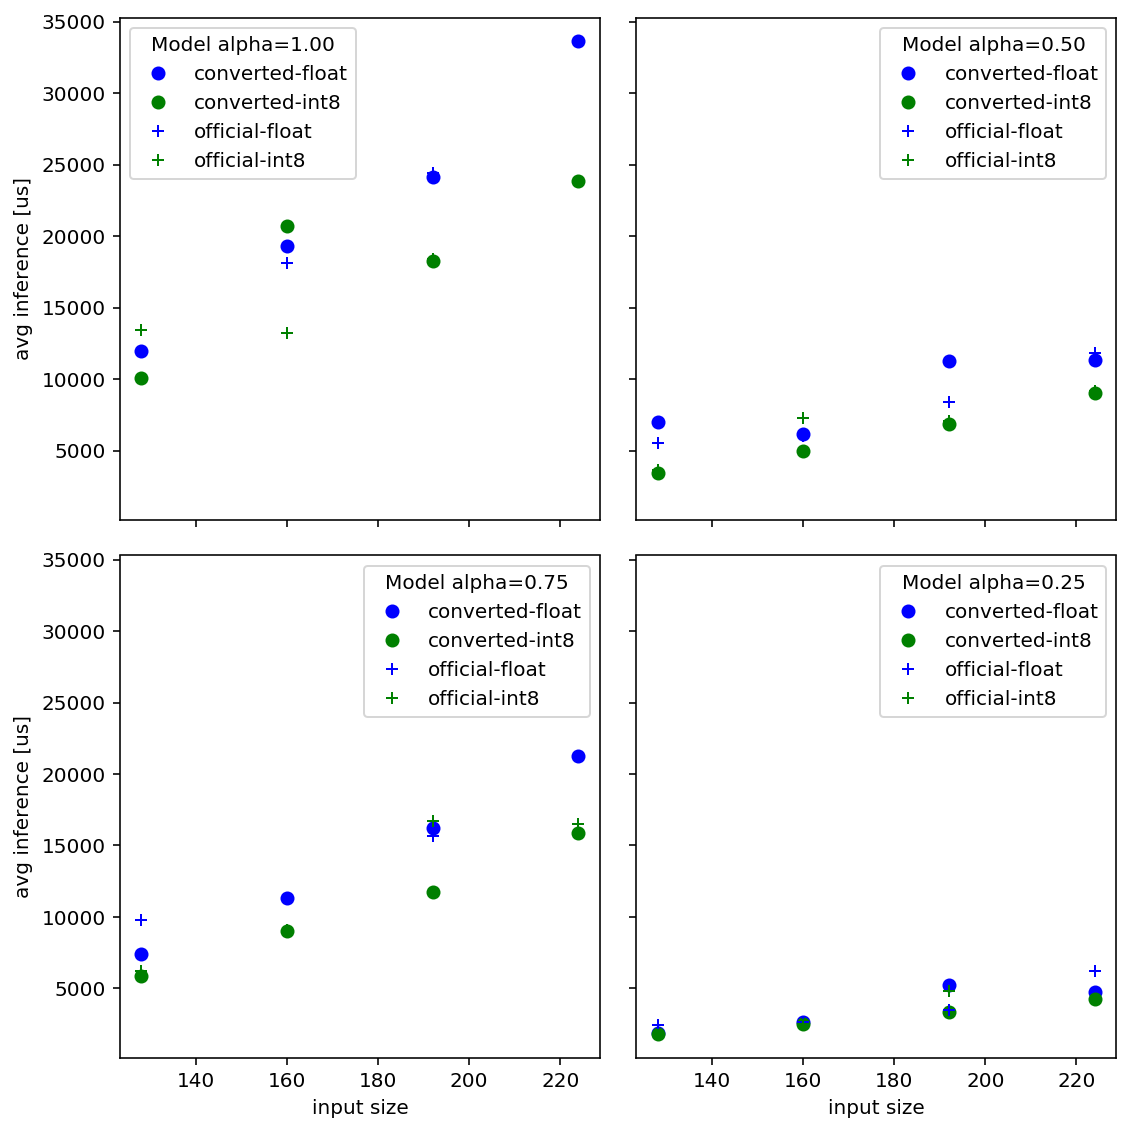

In [17]:
visualize(df, 'inference', 'avg inference [us]')

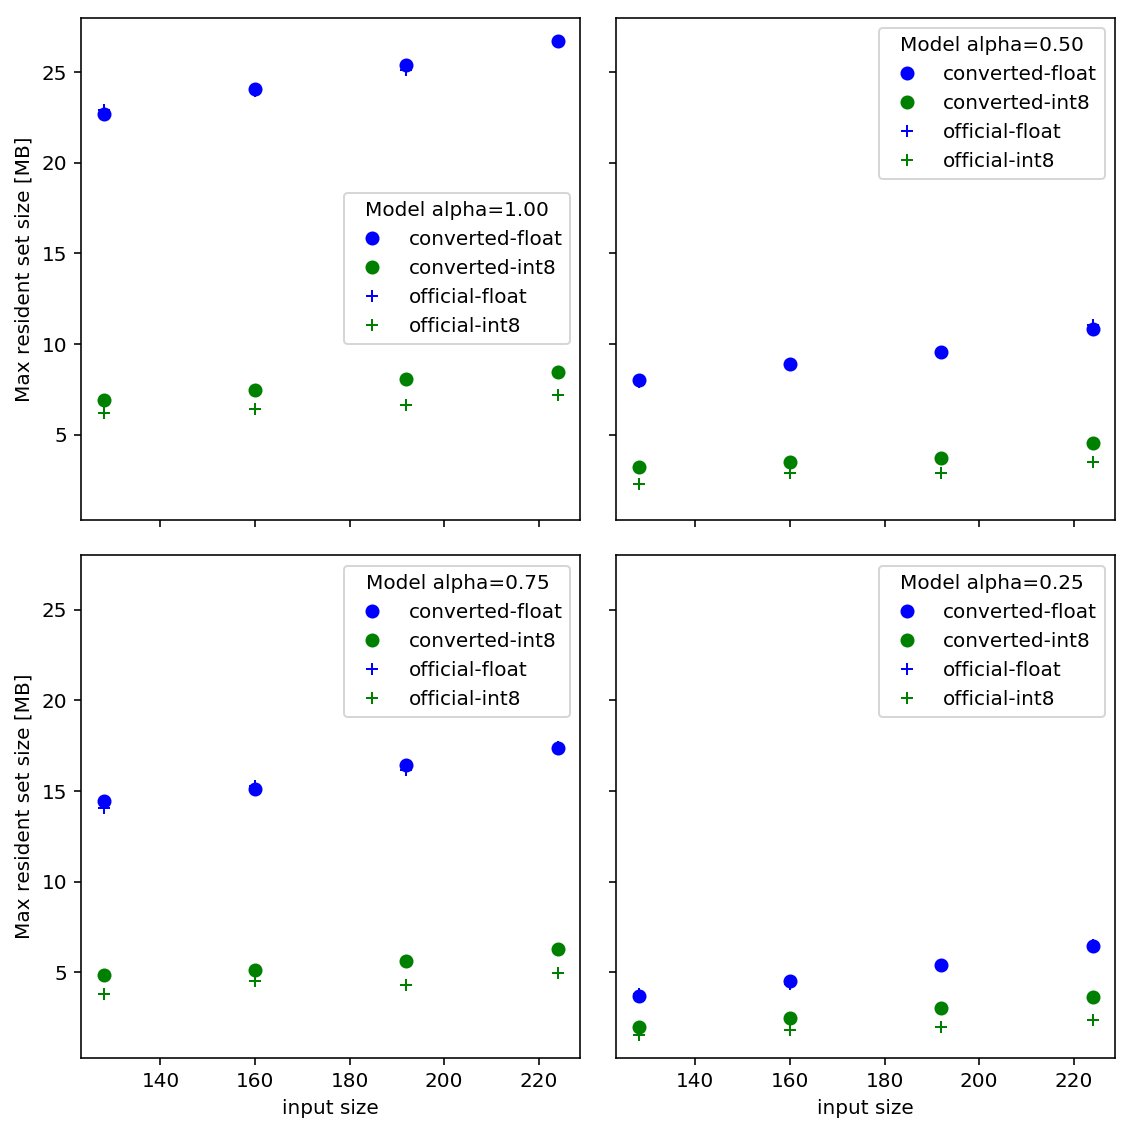

In [18]:
visualize(df, 'size_peak', 'Max resident set size [MB]')

In [1]:
import tensorflow as tf
tf.__version__

'2.0.0'

In [6]:
from tensorflow.python import keras
keras.__version__

'2.2.4-tf'